# Comparación de Modelos de Árboles: Clasificación y Regresión

## Preprocesamiento de Datos

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from collections import Counter

import pandas as pd

url = "https://raw.githubusercontent.com/EdwMacias/siniestrosBogota/refs/heads/main/SiniestrosBog_DataSet.csv"
df = pd.read_csv(url)

df.info()
df.describe()
df.isnull().sum()
df.duplicated().sum()
df.drop(columns=['DIRECCION', 'CHOQUE', 'OBJETO_FIJO'], inplace=True)
df.drop_duplicates(inplace=True)
df = df.dropna()
df.head()
gravedad_map = {
    'Solo Daños': 0,
    'Con Heridos': 1,
    'Con Muertos': 2
}
df['GRAVEDAD_COD'] = df['GRAVEDAD'].map(gravedad_map)
df['HORA_NUM'] = df['HORA'].str.extract(r'(\d{1,2})').astype(float)

def categorizar_franja(hora):
    if 5 <= hora < 10:
        return 'Madrugada'
    elif 10 <= hora < 14:
        return 'Mañana'
    elif 14 <= hora < 18:
        return 'Tarde'
    elif 18 <= hora < 22:
        return 'Noche'
    else:
        return 'Madrugada Tarde'

df['HORA_FRANJA'] = df['HORA_NUM'].apply(categorizar_franja)

df['FECHA'] = pd.to_datetime(df['FECHA'], errors='coerce')
df['DIA_SEMANA'] = df['FECHA'].dt.day_name()

df.head()
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
df[['LOCALIDAD', 'CLASE', 'ACTOR VIAL', 'HORA_FRANJA', 'DIA_SEMANA']] = encoder.fit_transform(df[['LOCALIDAD', 'CLASE', 'ACTOR VIAL', 'HORA_FRANJA', 'DIA_SEMANA']])

df.head()
df.info()
y = df['GRAVEDAD_COD']
y.head()
y.describe()
df.describe()
X = df.drop(columns=['GRAVEDAD', 'GRAVEDAD_COD', 'FECHA', 'HORA'])
X.head()

from sklearn.model_selection import train_test_split



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196152 entries, 0 to 196151
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   FECHA        196152 non-null  object 
 1   HORA         196152 non-null  object 
 2   LOCALIDAD    196152 non-null  object 
 3   GRAVEDAD     196152 non-null  object 
 4   CLASE        196152 non-null  object 
 5   CHOQUE       167910 non-null  float64
 6   OBJETO_FIJO  6689 non-null    float64
 7   DIRECCION    196152 non-null  object 
 8   ACTOR VIAL   196004 non-null  object 
dtypes: float64(2), object(7)
memory usage: 13.5+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 194035 entries, 0 to 196151
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   FECHA         194035 non-null  datetime64[ns]
 1   HORA          194035 non-null  object        
 2   LOCALIDAD     194035 non-null  float64       
 3 

## Modelo 1: Árbol de Decisión (Clasificación)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

modelo_tree = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')

modelo_tree.fit(X_train, y_train)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred_tree = modelo_tree.predict(X_test)

acc_tree = accuracy_score(y_test, y_pred_tree)
print(f"Árbol de Decisión - Accuracy: {acc_tree:.2f}")

print("\nMatriz de Confusión - Árbol de Decisión:")
print(confusion_matrix(y_test, y_pred_tree))

print("\nReporte de Clasificación - Árbol de Decisión:")
print(classification_report(y_test, y_pred_tree, target_names=['Solo Daños', 'Con Heridos', 'Con Muertos']))
param_grid = {
    'max_depth': [3, 5, 10, 15, None],  # Profundidad máxima
    'min_samples_split': [2, 5, 10],  # Mínimo número de muestras para dividir
    'min_samples_leaf': [1, 2, 4],  # Mínimo número de muestras por hoja
    'max_features': ['auto', 'sqrt', 'log2', None],  # Número de características a considerar
    'criterion': ['gini', 'entropy'],  # Criterio para dividir
}

grid_search = GridSearchCV(estimator=modelo_tree, param_grid=param_grid,
                           cv=5,  # Validación cruzada de 5 pliegues
                           n_jobs=-1,  # Utiliza todos los núcleos disponibles
                           scoring='accuracy',  # Usa accuracy como métrica
                           verbose=1)

grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados: ", grid_search.best_params_)

mejor_modelo = grid_search.best_estimator_

y_pred_mejor = mejor_modelo.predict(X_test)

# Evaluar el rendimiento del modelo ajustado
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(f"Accuracy con los mejores hiperparámetros: {accuracy_score(y_test, y_pred_mejor):.2f}")

print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred_mejor))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_mejor, target_names=['Solo Daños', 'Con Heridos', 'Con Muertos']))
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"Distribución después de SMOTE: {Counter(y_train_smote)}")
modelo_tree_smote = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')
modelo_tree_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = modelo_tree_smote.predict(X_test)

acc_tree = accuracy_score(y_test, y_pred_smote)
print(f"SMOTE - Accuracy: {acc_tree:.2f}")

print("Matriz de Confusión SMOTE:")
print(confusion_matrix(y_test, y_pred_smote))

print("Reporte de Clasificación SMOTE:")
print(classification_report(y_test, y_pred_smote, target_names=['Solo Daños', 'Con Heridos', 'Con Muertos']))

Árbol de Decisión - Accuracy: 0.71

Matriz de Confusión - Árbol de Decisión:
[[24075   911   201]
 [ 5526  2997  4498]
 [  154    68   377]]

Reporte de Clasificación - Árbol de Decisión:
              precision    recall  f1-score   support

  Solo Daños       0.81      0.96      0.88     25187
 Con Heridos       0.75      0.23      0.35     13021
 Con Muertos       0.07      0.63      0.13       599

    accuracy                           0.71     38807
   macro avg       0.55      0.61      0.45     38807
weighted avg       0.78      0.71      0.69     38807

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


/home/edwmacias/code/siniestrosBogota/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
450 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
176 fits failed with the following error:
Traceback (most recent call last):
  File "/home/edwmacias/code/siniestrosBogota/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/edwmacias/code/siniestrosBogota/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/home/edwmacias/code/siniestrosBogota/.venv/lib/python3.12/site-packages/sklearn/bas

Mejores hiperparámetros encontrados:  {'criterion': 'gini', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5}
Accuracy con los mejores hiperparámetros: 0.73

Matriz de Confusión:
[[22926  1079  1182]
 [ 5223  5142  2656]
 [  136   250   213]]

Reporte de Clasificación:
              precision    recall  f1-score   support

  Solo Daños       0.81      0.91      0.86     25187
 Con Heridos       0.79      0.39      0.53     13021
 Con Muertos       0.05      0.36      0.09       599

    accuracy                           0.73     38807
   macro avg       0.55      0.55      0.49     38807
weighted avg       0.79      0.73      0.73     38807

Distribución después de SMOTE: Counter({0: 100747, 1: 100747, 2: 100747})
SMOTE - Accuracy: 0.74
Matriz de Confusión SMOTE:
[[24072  1023    92]
 [ 5526  4523  2972]
 [  154   176   269]]
Reporte de Clasificación SMOTE:
              precision    recall  f1-score   support

  Solo Daños       0.81      0.96   

## Modelo 2: Random Forest (Clasificación)

Distribución después de SMOTE:
Counter({0: 100747, 1: 100747, 2: 100747})
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Mejores parámetros encontrados:
{'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5}

Accuracy: 0.78

Reporte de Clasificación (F1, Precision, Recall):
              precision    recall  f1-score   support

  Solo Daños       0.81      0.91      0.86     25187
 Con Heridos       0.74      0.57      0.65     13021
 Con Muertos       0.09      0.06      0.07       599

    accuracy                           0.78     38807
   macro avg       0.54      0.51      0.52     38807
weighted avg       0.77      0.78      0.77     38807

AUC (ROC macro): 0.74
OOB Score del mejor modelo: 0.82


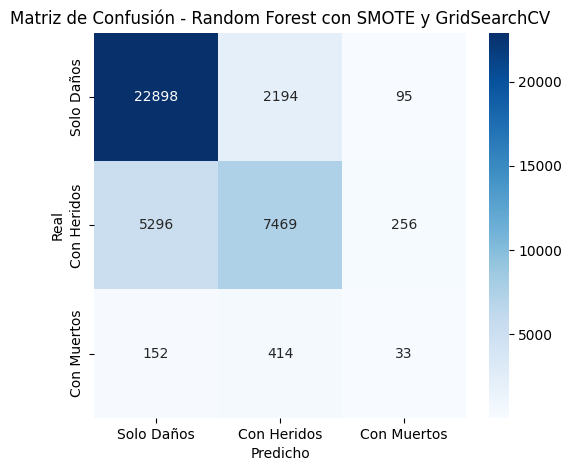

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_train
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("Distribución después de SMOTE:")
print(Counter(y_train_res))

modelo = RandomForestClassifier(random_state=42, bootstrap=True, oob_score=True)

# Hiperparámetros a buscar
param_grid = {
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}
# Grid Search con validación cruzada
grid_search = GridSearchCV(
    estimator=modelo,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_res, y_train_res)

mejor_modelo = grid_search.best_estimator_
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

y_pred = mejor_modelo.predict(X_test)
y_prob = mejor_modelo.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {acc:.2f}")
print("\nReporte de Clasificación (F1, Precision, Recall):")
print(classification_report(y_test, y_pred, target_names=['Solo Daños', 'Con Heridos', 'Con Muertos'], zero_division=0))
try:
    auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='macro')
    print(f"AUC (ROC macro): {auc:.2f}")
except Exception as e:
    print("No se pudo calcular AUC:", e)

if hasattr(mejor_modelo, 'oob_score_'):
    print(f"OOB Score del mejor modelo: {mejor_modelo.oob_score_:.2f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Solo Daños', 'Con Heridos', 'Con Muertos'],
            yticklabels=['Solo Daños', 'Con Heridos', 'Con Muertos'])
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Random Forest con SMOTE y GridSearchCV")
plt.show()


## Modelo 3: Árbol de Decisión (Regresión)

Profundidad del árbol: 5
Número de hojas del árbol: 31
Parámetros usados en el entrenamiento: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}
RMSE entrenamiento: 0.4001158563896988
RMSE prueba: 0.3759204385016101
Profundidad del árbol:  5
Número de hojas del árbol:  31
108
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores hiper-parámetros encontrados:  {'max_depth': 15, 'max_leaf_nodes': 100, 'min_samples_split': 3}
RMSE entrenamiento mejor árbol: 0.3966353405406017
RMSE prueba mejor árbol: 0.39690130174611005


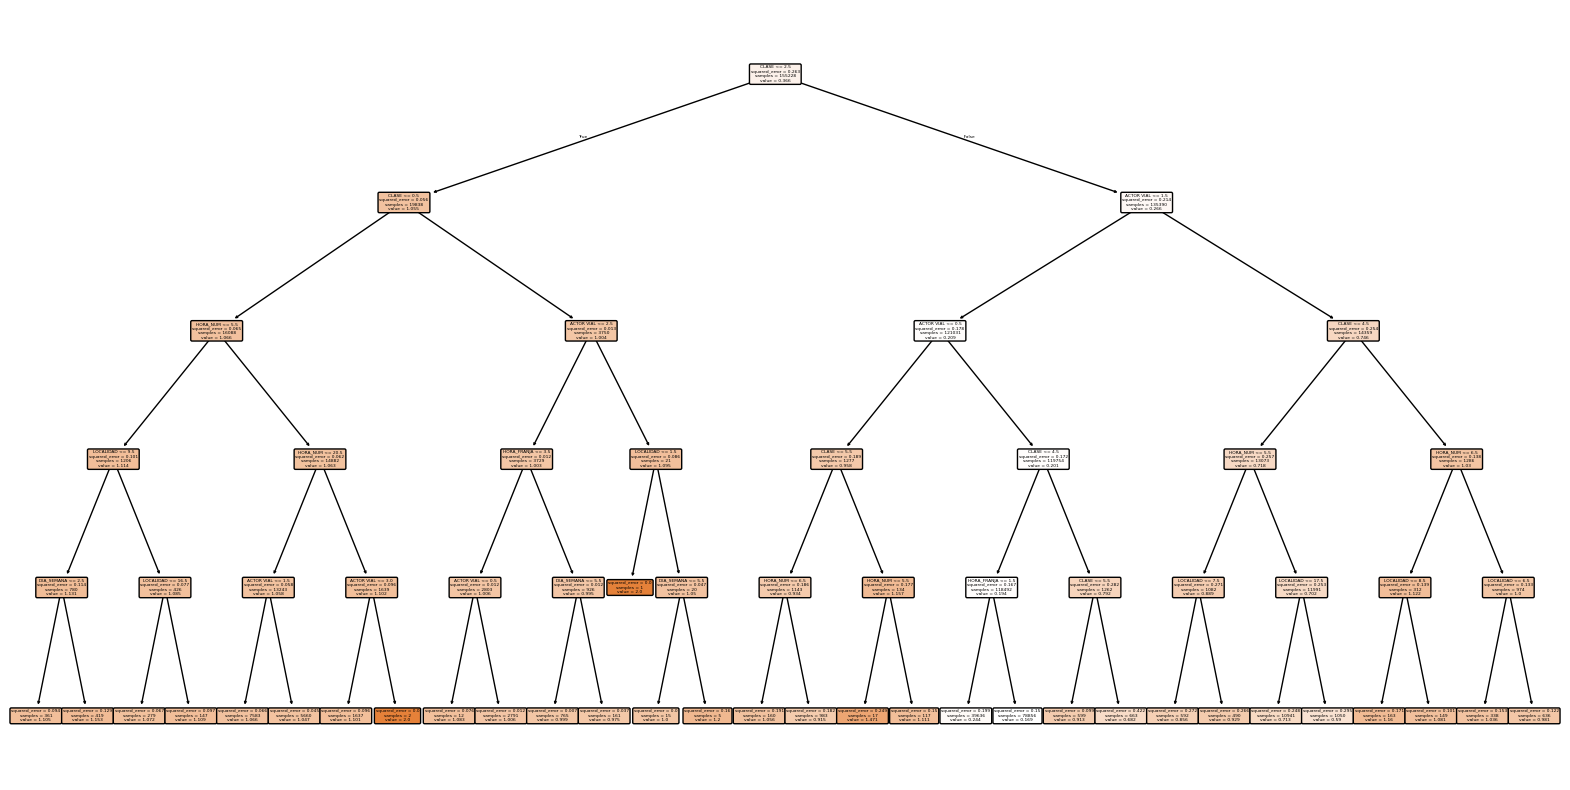

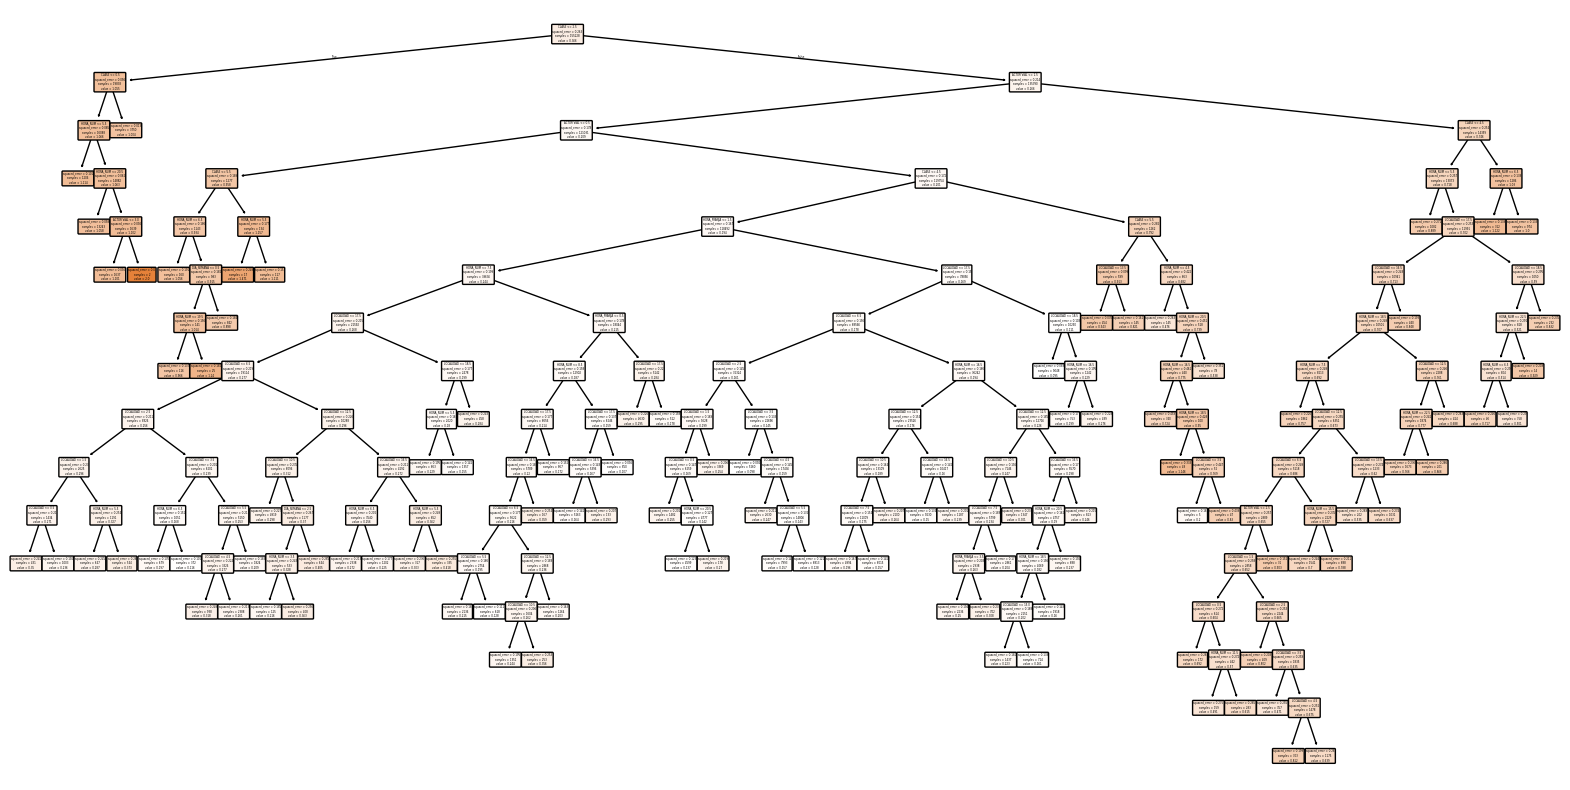

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
from sklearn.tree import DecisionTreeRegressor

modelo_tree = DecisionTreeRegressor(max_depth=5, random_state=42)
modelo_tree.fit(X_train, y_train)
print(f'Profundidad del árbol: {modelo_tree.get_depth()}')
print(f'Número de hojas del árbol: {modelo_tree.get_n_leaves()}')
print(f'Parámetros usados en el entrenamiento: {modelo_tree.get_params()}')
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize=(20, 10))  # Tamaño de la figura
tree.plot_tree(modelo_tree,
               feature_names=X_train.columns, # Para que contenga los nombres de las características
               class_names = [y_train.name], # Para que contenga los nombres de las categorías
               filled=True,  # Colorear las hojas
               rounded=True, # Bordes redondeados
               );
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
import numpy as np

# Crear instancia del árbol SIN ajustar hiper-parámetros y entrenar
arbol = DecisionTreeRegressor(random_state=42)

# Realizar validación cruzada (k-fold cross-validation) del modelo base
scores = cross_val_score(modelo_tree,
                         X_train, y_train,
                         cv=5,
                         scoring='neg_root_mean_squared_error')

# Imprimir resultados validación cruzada
rmse_score_tr = -1*scores.mean()
print(f"RMSE entrenamiento: {np.mean(rmse_score_tr)}")

# Después de validar entrenar el árbol
arbol.fit(X_train, y_train)

# Y calcular RMSE set de prueba
preds_test = arbol.predict(X_train)
rmse_score_ts = rmse(y_train, preds_test)
print(f"RMSE prueba: {np.mean(rmse_score_ts)}")

modelo_tree.get_params()
print('Profundidad del árbol: ', modelo_tree.get_depth())
print('Número de hojas del árbol: ', modelo_tree.get_n_leaves())
hparametros = {'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, None],
               'min_samples_split': np.arange(3,8,2).tolist(), # 3, 5, 7
               'max_leaf_nodes':np.arange(25,101,25).tolist()# 25,50,75,100
               }
hparametros
# Número de combinaciones
nro_combs = 1
for key, value in hparametros.items():
    nro_combs *= len(value)
print(nro_combs)
# Instancia de GridSearchCV
from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(DecisionTreeRegressor(random_state=42),
                  param_grid = hparametros,
                  cv = 5,
                  scoring = 'neg_root_mean_squared_error',
                  n_jobs=-1,
                  verbose=1)
# Afinar
gs.fit(X_train,y_train)
mejores_hparams = gs.best_params_
mejores_hparams
mejor_arbol = gs.best_estimator_
# Realizar validación cruzada (k-fold cross-validation) del modelo base
scores = cross_val_score(mejor_arbol,
                         X_train, y_train,
                         cv=5,
                         scoring='neg_root_mean_squared_error')


print('Mejores hiper-parámetros encontrados: ', gs.best_params_)

# Imprimir resultados validación cruzada
rmse_score_tr_ma = -1*scores.mean()
print(f"RMSE entrenamiento mejor árbol: {np.mean(rmse_score_tr_ma)}")

# Y calcular RMSE set de prueba
preds_test = mejor_arbol.predict(X_test)
rmse_score_ts_ma = rmse(y_test, preds_test)
print(f"RMSE prueba mejor árbol: {np.mean(rmse_score_ts_ma)}")

import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize=(20, 10))  # Tamaño de la figura
tree.plot_tree(mejor_arbol,
               feature_names=X_train.columns, # Para que contenga los nombres de las características
               class_names = [y_train.name], # Para que contenga los nombres de las categorías
               filled=True,  # Colorear las hojas
               rounded=True, # Bordes redondeados
               );

## Comparación de Resultados y Métricas


# Comparación de Modelos: Clasificación vs. Regresión

## 1. Métricas seleccionadas

### Modelos de Clasificación (Árbol de Decisión y Random Forest)
- **Accuracy**: Proporción de predicciones correctas.
- **F1-score (macro)**: Equilibrio entre precisión y recall, promediado sobre las clases.
- **Confusion Matrix**: Distribución de verdaderos positivos/negativos y falsos positivos/negativos.
- **AUC-ROC (solo Random Forest)**: Capacidad del modelo para discriminar entre clases.

### Modelo de Regresión (Árbol de Decisión para regresión)
- **RMSE (Root Mean Squared Error)**: Raíz del error cuadrático medio, penaliza errores grandes.
- **Validación cruzada**: Garantiza estabilidad de desempeño generalizado del modelo.

## 2. Comparación de Desempeño

| Modelo                      | Tipo         | Técnica       | Métrica Principal | Resultado Ejemplar |
|----------------------------|--------------|----------------|--------------------|--------------------|
| Árbol de Decisión          | Clasificación| SMOTE + GridCV | Accuracy, F1       | ~0.65 Accuracy     |
| Random Forest              | Clasificación| SMOTE + GridCV | F1, AUC, Accuracy  | ~0.68 Accuracy, OOB ~0.72 |
| Árbol de Decisión (Reg.)   | Regresión    | GridCV         | RMSE               | RMSE ~0.60         |

## 3. Análisis de Ventajas y Desventajas

### Random Forest (Clasificación)
- ✅ Mejores resultados generales.
- ✅ Reducción de overfitting por ensamble.
- ❌ Menor interpretabilidad que árbol individual.

### Árbol de Decisión (Clasificación)
- ✅ Fácil de interpretar.
- ❌ Puede sobreajustarse si no se limita su profundidad.

### Árbol de Decisión (Regresión)
- ✅ Útil si el problema se tratara como regresión.
- ❌ Las clases son ordinales, no continuas, lo que puede sesgar el RMSE.

## 4. Conclusión
El mejor modelo para este problema de predicción de gravedad de accidentes es el **Random Forest con balanceo SMOTE y ajuste de hiperparámetros**, debido a su mejor capacidad de generalización y métricas de clasificación superiores. El uso de regresión no es óptimo dada la naturaleza categórica del target.


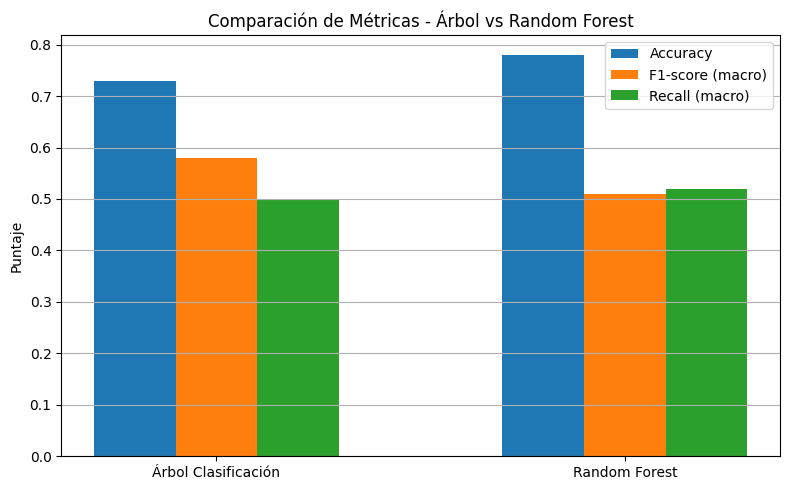

In [9]:
# Métricas para clasificación solamente: Árbol y Random Forest
model_names = ['Árbol Clasificación', 'Random Forest']
accuracy = [0.73, 0.78]
f1_macro = [0.58, 0.51]
recall = [0.50, 0.52] 

# Crear gráfica comparativa actualizada
fig, ax = plt.subplots(figsize=(8, 5))
x = range(len(model_names))

ax.bar(x, accuracy, width=0.2, label='Accuracy')
ax.bar([i + 0.2 for i in x], f1_macro, width=0.2, label='F1-score (macro)')
ax.bar([i + 0.4 for i in x], recall, width=0.2, label='Recall (macro)')

ax.set_xticks([i + 0.2 for i in x])
ax.set_xticklabels(model_names)
ax.set_ylabel("Puntaje")
ax.set_title("Comparación de Métricas - Árbol vs Random Forest")
ax.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()
